<a href="https://colab.research.google.com/github/adiogale/DGM/blob/main/b_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)


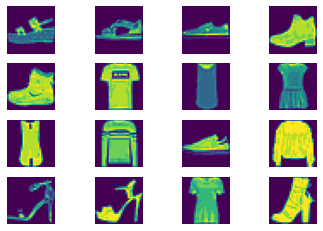

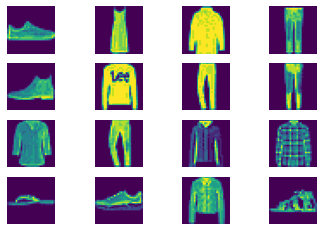

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from keras.datasets import fashion_mnist
import tensorflow as tf

(xtrain, ytrain), (xtest, ytest) = fashion_mnist.load_data()
var_num = 784
xtrain = np.round(xtrain / 27).astype(int);
xtest = np.round(xtest / 27).astype(int);

xtrain_flat = np.reshape(xtrain, (-1,var_num))
xtest_flat = np.reshape(xtest, (-1,var_num)) 

train_size = xtrain_flat.shape[0]
test_size = xtest_flat.shape[0]
batch_size = 100
train_dataset = (tf.data.Dataset.from_tensor_slices(xtrain).shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(xtest).shuffle(test_size).batch(batch_size))

print(xtrain.shape)
# print(test_dataset.shape)
def draw_grid(imlist, m, n):
  fig, grid = plt.subplots(m,n) 
  for i in range(m):
    for j in range(n):
      grid[i,j].axis('off')
      grid[i,j].imshow(np.reshape(imlist[(i-1)*m+j], (28,28)))

draw_grid(xtrain[:16], 4,4)
draw_grid(xtest[:16],4,4)

In [ ]:
from torch.nn.modules.conv import ConvTranspose2d
from torch.nn.modules.flatten import Unflatten
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.autograd as ag
from torch.nn import functional as F
from torch.distributions.categorical import Categorical
from torch.nn import LSTMCell
import numpy as np

class b_VAE(nn.Module):
  def __init__(self, h_size, beta, device):
    super(b_VAE, self).__init__()
    self.h_size = h_size
    self.beta = beta
    self.device = device

    self.encoder = nn.Sequential(
        # batch, 1, 28, 28
        nn.Conv2d(1, 32, 3, padding = 1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d((2,2)),

        # batch, 32, 14, 14
        nn.Conv2d(32, 64, 3, padding = 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d((2,2)),

        # batch, 64, 7, 7
        nn.Conv2d(64, 128, 3, padding = 1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d((2,2)),

        # batch, 128, 3, 3
        nn.Conv2d(128, 256, 3, padding = 1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d((2,2)),
        
        # batch, 256, 1, 1
        nn.Flatten(start_dim=1, end_dim=3),

        # # batch, 256
        nn.Linear(256, self.h_size*2)

        # Output dim = batch, 256, h_size * 2
    )

    self.decoder = nn.Sequential(
        # in: batch, h_size
        nn.Linear(self.h_size, 256),

        # in: batch, 256
        nn.Unflatten(dim=1, unflattened_size=(256, 1, 1)),

        # in: batch, 256, 1, 1
        nn.ConvTranspose2d(256, 128, kernel_size=3),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        # in: batch, 128, 3, 3
        nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        # in: batch, 64, 7, 7
        nn.ConvTranspose2d(64, 32, kernel_size=3, stride = 2, padding=1, output_padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),

        # in: batch, 32, 14, 14
        nn.ConvTranspose2d(32, 10, kernel_size=3, stride = 2, padding=1, output_padding=1),
        nn.BatchNorm2d(10),

        # out: batch, 10, 28, 28        
    )

  def reparam(self, mu, logvar):
    # mu + noise*exp(logvar/2)
    return mu + torch.randn_like(logvar) * torch.exp(logvar/2)

  def forward(self, data):
    z = self.encoder(data)
    z = z.chunk(2, dim=1)
    self.mu, self.logvar = z[0], z[1]
    z = self.reparam(self.mu, self.logvar)
    x_hat = self.decoder(z)
    return x_hat


  def loss(self, x_hat, data):
    # x_hat = batch, 10, 28, 28     data = batch, 1, 28, 28
    x_hat = torch.flatten(x_hat, start_dim = 2)
    data = torch.flatten(data, start_dim = 1)
    reconstruction_loss = nn.CrossEntropyLoss(reduction='sum')(x_hat, data)/data.shape[0]
    kl_regularize = torch.mean(-0.5*torch.sum(1 + self.logvar - self.mu.pow(2) - self.logvar.exp(),dim=1),dim=0)
    return reconstruction_loss, kl_regularize


  def sample(self, no_samples):
    z = torch.randn(no_samples, self.h_size, device=self.device)
    x_prob = self.decoder(z)
    x_soft = torch.log_softmax(x_prob, dim=1).permute(0,2,3,1)
    x_hat = Categorical(logits=x_soft).sample()
    return x_hat

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
beta = 0.2
h_size = 100
model = b_VAE(h_size, beta, device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10

def train(model, optimizer, train_dataset, beta, device):
    rec_loss_list = []
    kl_loss_list = []
    for batch, data in enumerate(train_dataset):
      data = torch.tensor(data.numpy(), device=device)
      data = data.unsqueeze(1)
      pred = model(data.type(torch.FloatTensor).to(device))
      rec_loss, kl_loss = model.loss(pred, data)
      rec_loss_list.append(rec_loss)
      kl_loss_list.append(kl_loss)
      loss = rec_loss + beta * kl_loss
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if batch % 200 == 0 and batch!=0:
        print("loss: ", loss.item(), " for batch: ", batch, " of ", batch_size, " images. \t Recon_loss = ", rec_loss.item(), "\t KL_Loss = ", kl_loss.item())
    return model, rec_loss_list, kl_loss_list

# for data in train_dataset:
for i in range(epochs):
  model,rec, kl = train(model, optimizer, train_dataset, beta, device)
  print("Epoch ", i+1)

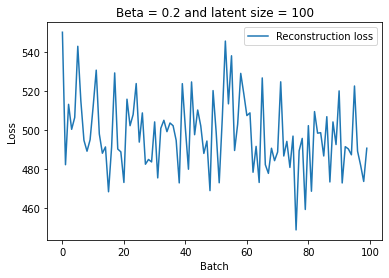

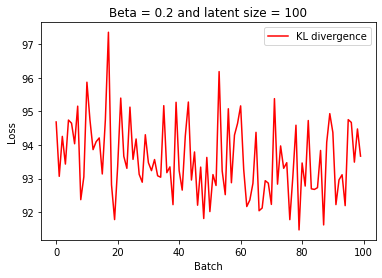

In [ ]:
# model = b_VAE(50, 0.2, device)
# model.load_state_dict(torch.load("/content/b0_2h_50"))
# model.eval()

def test(model, optimizer, train_dataset, beta, device):
    rec_loss_list = []
    kl_loss_list = []
    for batch, data in enumerate(train_dataset):
      data = torch.tensor(data.numpy(), device=device)
      data = data.unsqueeze(1)
      pred = model(data.type(torch.FloatTensor).to(device))
      rec_loss, kl_loss = model.loss(pred, data)
      rec_loss_list.append(rec_loss.item())
      kl_loss_list.append(kl_loss.item())
      loss = rec_loss + beta * kl_loss
    return rec_loss_list, kl_loss_list


rec_test, kl_test = test(model, optimizer, test_dataset, beta, device)
x_axis = list(range(100))

plt.plot(x_axis, rec_test, label = 'Reconstruction loss')
# plt.plot(x_axis, kl_test, label = 'KL divergence')
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Beta = 0.2 and latent size = 100")
plt.legend()
plt.show()
plt.plot(x_axis, kl_test, 'r', label = 'KL divergence')
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Beta = 0.2 and latent size = 100")
plt.legend()
plt.show()

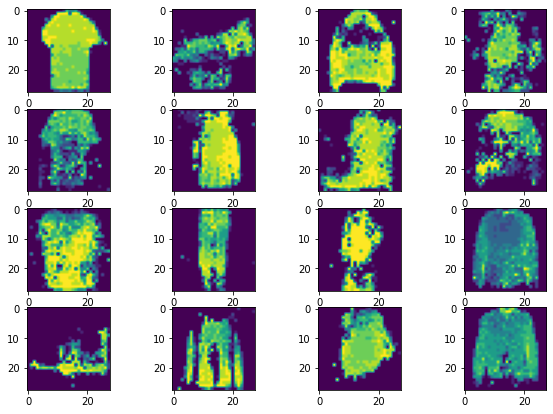

In [ ]:
outputs = model.sample(16).reshape(16, 28, 28)
import matplotlib.pyplot as plt 
fig = plt.figure(figsize=(10, 7))
rows = 4
columns = 4

for i in range(16):
  # Adds a subplot at the 4th position
  fig.add_subplot(rows, columns, i+1)
  # showing image
  plt.imshow(outputs[i].cpu())

In [ ]:
# torch.save(model.state_dict(), 'b2h100')

In [ ]:
def sample_px(model, no_samples):
    z = torch.randn(no_samples, model.h_size, device=model.device)
    x_prob = model.decoder(z)
    x_soft = torch.log_softmax(x_prob, dim=1).permute(0,2,3,1)
    x_hat = Categorical(logits=x_soft).sample()
    return x_hat, x_soft

x_hat, x_soft = sample_px(model, 500)
print(x_hat.shape)
print(x_soft.shape)

TypeError: ignored

In [ ]:
X = torch.Tensor().to(device)
y = torch.Tensor().to(device)
with torch.no_grad():
  for batch, data in enumerate(train_dataset):
        data = torch.tensor(data.numpy(), device=device)
        data = data.unsqueeze(1)
        z = model.encoder(data.type(torch.FloatTensor).to(device))
        z = z.chunk(2, dim=1)
        mu, logvar = z[0], z[1]
        p_z = torch.randn_like(mu)
        q_z = mu + p_z*logvar

        p_label = torch.ones(p_z.shape[0]).to(device)
        # p_tensor = torch.cat((p_z, p_label), 1)
        X = torch.cat((X, p_z),0).to(device)
        y = torch.cat((y, p_label), 0).to(device)
        
        q_label = torch.zeros(q_z.shape[0]).to(device)
        # q_tensor = torch.Tensor((q_z, q_label))
        X = torch.cat((X, q_z), 0).to(device)
        y = torch.cat((y, q_label), 0).to(device)
print(X.shape)
print(y.shape)

torch.Size([120000, 100])
torch.Size([120000])


In [ ]:
print(X.shape)

torch.Size([120000, 100])


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

class_data = TensorDataset(X, y)
dataloader = DataLoader(class_data, shuffle=True, batch_size = 100)

In [ ]:
class Classifier(nn.Module):
  def __init__(self, h_size, device):
    super(Classifier,self).__init__()
    self.h_size = h_size
    self.device = device
    self.model_seq = nn.Sequential(
        nn.Linear(self.h_size, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 8),
        nn.ReLU(),
        nn.Linear(8,4),
        nn.ReLU(),
        nn.Linear(4,1),
        nn.ReLU(),
        nn.Sigmoid(),
    )
  
  def forward(self, X):
    out = self.model_seq(X)
    return out

  def loss(self, out, X):
    # print(X.shape)
    return nn.BCELoss(reduction='sum')(out, X)/X.shape[0]

  def energy_calc(self, z):
    out = self.forward(z)
    r = out/(1-out)
    PI = torch.from_numpy(np.asarray(np.pi))
    log_p = -0.5*z.shape[1] * torch.log(2*PI) - 0.5 * z**2
    sum_p = torch.sum(log_p, dim=0)
    r = torch.sum(r,dim=0)
    # e = 
    return -torch.log(r) - sum_p

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
beta = 1
model_cl = Classifier(100, device).to(device)
optimizer = torch.optim.Adam(model_cl.parameters(), lr=0.01)
epochs = 1

def train(model_cl, optimizer, dataset, device):
    for batch, (x, y) in enumerate(dataset):
      # X = torch.tensor(data[0].numpy(), device=device)
      pred = model_cl(x.type(torch.FloatTensor).to(device))
      # print(pred.shape)
      # print(y.shape)
      loss = model_cl.loss(pred, y.unsqueeze(1))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if batch % 200 == 0 and batch!=0:
        print("loss: ", loss.item(), " for batch: ", batch, " of ", batch_size, " images.")
    return model_cl


for i in range(epochs):
  model_cl = train(model_cl, optimizer, dataloader, device)
  print("Epoch ", i+1)


loss:  0.6931471824645996  for batch:  200  of  100  images.
loss:  0.6931471824645996  for batch:  400  of  100  images.
loss:  0.6931471824645996  for batch:  600  of  100  images.
loss:  0.6931471824645996  for batch:  800  of  100  images.
loss:  0.6931471824645996  for batch:  1000  of  100  images.
Epoch  1


In [ ]:
def sample(no_samples):
    z = torch.randn(no_samples, h_size, device=device)
    x_prob = model.decoder(z)
    z.requires_grad = True
    # print(x_prob.shape)
    for i in range(100):
      energy = model_cl.energy_calc(z).sum().backward()
      eps = 0.1 * (10+i)**(-1)
      sigma = np.sqrt(eps)
      eta = sigma * torch.randn(no_samples, h_size, device=device)
      z.data -= (eps/2) * z.grad - eta
      z.grad.zero_()
    # print(z.shape)
    z_sample = model.decoder(z)
    z_soft = torch.log_softmax(z_sample, dim=1).permute(0,2,3,1)
    z_hat = Categorical(logits=z_soft).sample()
    x_soft = torch.log_softmax(x_prob, dim=1).permute(0,2,3,1)
    x_hat = Categorical(logits=x_soft).sample()
    return x_hat, z_hat

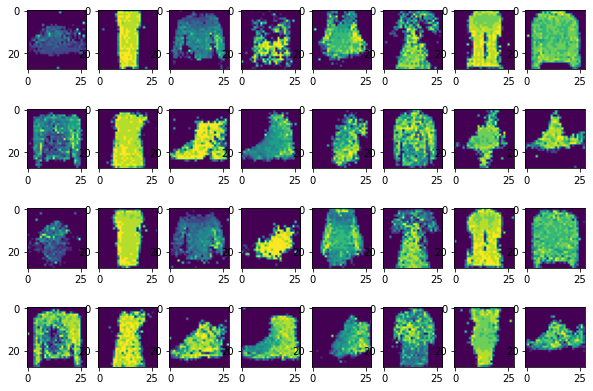

In [ ]:
beta_out, energy_out = sample(16)     ##.reshape(32, 28, 28)

# print(beta.shape)

import matplotlib.pyplot as plt 
fig = plt.figure(figsize=(10, 7))
rows = 4
columns = 8

count = 0

for i in range(32):
  # Adds a subplot at the 4th position
  fig.add_subplot(rows, columns, i+1)
  if count < 16:
    plt.imshow(beta_out[i].cpu())
    count+=1  
  else:
    plt.imshow(energy_out[i-16].cpu())
